In [1]:
import cvxpy as cp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import yfinance as yf
plt.style.use('seaborn-whitegrid')
HOME = os.environ['HOME']  + '/Documents/ESG/'

from itertools import combinations, permutations
def process_data(year: int = 2020) -> pd.DataFrame:
    df = pd.read_csv(HOME + '/{year}_data.csv'.format(year=year)).drop('Unnamed: 0', axis=1).rename(columns={'Scope 2 (Mkt)': 'Scope 2'}) ##### GHG in mtCO2e
    df.loc[df.Ticker == 'ATT', 'Ticker'] = 'T'
    for col in list(df.columns[2:-1]):
        df[col] = df[col].str.replace(',', '').str.replace(' billion', '000000000').astype(float)
    for k in range(1,4):
        df['INTENSITY_{}'.format(k)] = df['Scope {}'.format(k)] / df.Revenue
        df['INTENSITY_{}_RANK'.format(k)] = df['INTENSITY_{}'.format(k)].rank(ascending=False)
    return df.sort_values('INTENSITY_1', ascending=False).reset_index(drop=True)

df = process_data(2020)

/Users/kq/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/kq/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
scopes = ['Scope {j}'.format(j=j) for j in range(1,4)]

In [3]:
sectors = df['Sectors'].unique().tolist()

### Slope of scope pairs

We consider the pairwise permutations of all scopes (unnormalized). It seems reasonable that 2/3 have the highest slope due to estimation error.

In [363]:
%matplotlib inline
hashmap = {}
scopes = ['Scope {j}'.format(j=j) for j in range(1,4)]
scope_pairs = list(permutations(scopes, 2))
from sklearn import linear_model
for x,y in scope_pairs:
    sub = df[(df[x].notnull()) & (df[y].notnull())]
    reg = linear_model.LinearRegression()
    reg.fit(sub[x].values.reshape(-1, 1), sub[y].values.reshape(-1, 1))
    hashmap[x,y] = reg.coef_[0][0]
pd.Series(hashmap).sort_values()

Scope 3  Scope 2    0.005170
Scope 1  Scope 2    0.049686
Scope 3  Scope 1    0.099669
Scope 2  Scope 1    1.635750
Scope 1  Scope 3    3.061605
Scope 2  Scope 3    6.738040
dtype: float64

### Slope of scope pairs by sector

In [365]:
hashmap = {}
for sector in sectors:
    for x,y in scope_pairs:
        sub = df[(df[x].notnull()) & (df[y].notnull()) & (df['Sectors'] == sector)]
        reg = linear_model.LinearRegression()
        reg.fit(sub[x].values.reshape(-1, 1), sub[y].values.reshape(-1, 1))
        hashmap[sector, x,y] = reg.coef_[0][0]
pd.Series(hashmap).to_frame()[0].unstack().fillna(1)

Scope 1   Scope 2     Scope 3
Communication Services Scope 1   1.000000  3.178997   -0.964378
                       Scope 2   0.150142  1.000000    1.154778
                       Scope 3  -0.005737  0.162185    1.000000
Consumer Discretionary Scope 1   1.000000  0.495441   -0.893793
                       Scope 2   1.676267  1.000000   16.398201
                       Scope 3  -0.000884  0.004796    1.000000
Consumer Staples       Scope 1   1.000000  0.994818   36.400786
                       Scope 2   0.765191  1.000000  -14.971314
                       Scope 3   0.007129 -0.000716    1.000000
Energy                 Scope 1   1.000000  0.060239    4.909938
                       Scope 2  13.176711  1.000000   41.323511
                       Scope 3   0.151060  0.005817    1.000000
Financials             Scope 1   1.000000 -0.078199   24.500023
                       Scope 2  -0.028359  1.000000    3.670107
                       Scope 3   0.013145  0.005903    1.000000
Health Care            Scope 1   1.000000  0.539654    6.083218
                       Scope 2   0.298368  1.000000    8.267712
                       Scope 3   0.006404  0.022388    1.000000
Industrials            Scope 1   1.000000  0.008897   -3.587473
                       Scope 2   3.894013  1.000000 -148.269842
                       Scope 3  -0.023938 -0.001516    1.000000
Information Technology Scope 1   1.000000  0.387305    2.493475
                       Scope 2   1.784141  1.000000   -1.451953
                       Scope 3   0.010400 -0.001315    1.000000
Materials              Scope 1   1.000000  0.241504    1.856193
                       Scope 2   0.342209  1.000000   -0.743676
                       Scope 3   0.378187 -0.106930    1.000000
Real Estate            Scope 1   1.000000  0.661259    4.876790
                       Scope 2   1.512268  1.000000    7.375012
                       Scope 3   0.205053  0.135593    1.000000
Utilities              Scope 1   1.000000 -0.065694   -0.831947
                       Scope 2 -11.363822  1.000000   16.676101
                       Scope 3  -0.566962  0.053347    1.000000

### Slope of intensity pairs

On a revenue-normalized basis, the slopes are a lot more sensible.

In [367]:
hashmap = {}
intensity = ['INTENSITY_{j}'.format(j=j) for j in range(1,4)]
intensity_pairs = list(permutations(intensity, 2))
from sklearn import linear_model
for x,y in intensity_pairs:
    sub = df[(df[x].notnull()) & (df[y].notnull())]
    reg = linear_model.LinearRegression()
    reg.fit(sub[x].values.reshape(-1, 1), sub[y].values.reshape(-1, 1))
    hashmap[x,y] = reg.coef_[0][0]
intensity_betas = pd.Series(hashmap)
intensity_betas.sort_values()

INTENSITY_3  INTENSITY_2    0.006505
INTENSITY_1  INTENSITY_2    0.023887
INTENSITY_3  INTENSITY_1    0.086929
INTENSITY_1  INTENSITY_3    0.460683
INTENSITY_2  INTENSITY_1    0.714664
             INTENSITY_3    0.887183
dtype: float64

### Slope of intensity pairs by sector

In [368]:
hashmap = {}
for sector in sectors:
    for x,y in intensity_pairs:
        sub = df[(df[x].notnull()) & (df[y].notnull()) & (df['Sectors'] == sector)]
        reg = linear_model.LinearRegression()
        reg.fit(sub[x].values.reshape(-1, 1), sub[y].values.reshape(-1, 1))
        hashmap[sector, x,y] = reg.coef_[0][0]
sector_intensities = pd.Series(hashmap).to_frame()[0].unstack().fillna(1)
sector_intensities

INTENSITY_1  INTENSITY_2  INTENSITY_3
Communication Services INTENSITY_1     1.000000     1.203173    -6.091115
                       INTENSITY_2     0.107587     1.000000     0.852053
                       INTENSITY_3    -0.046254     0.116556     1.000000
Consumer Discretionary INTENSITY_1     1.000000     0.369662   -18.730408
                       INTENSITY_2     0.400053     1.000000    94.308303
                       INTENSITY_3    -0.001091     0.005075     1.000000
Consumer Staples       INTENSITY_1     1.000000     0.118329    23.297120
                       INTENSITY_2     0.385373     1.000000    -0.882739
                       INTENSITY_3     0.004152    -0.000046     1.000000
Energy                 INTENSITY_1     1.000000     0.006855     8.010131
                       INTENSITY_2     3.326829     1.000000   -93.811574
                       INTENSITY_3     0.087156    -0.003516     1.000000
Financials             INTENSITY_1     1.000000    -0.401718    32.439249
                       INTENSITY_2    -0.031450     1.000000    -1.068750
                       INTENSITY_3     0.006714    -0.003444     1.000000
Health Care            INTENSITY_1     1.000000     0.704643     4.371066
                       INTENSITY_2     1.073169     1.000000     0.761084
                       INTENSITY_3     0.006957     0.001459     1.000000
Industrials            INTENSITY_1     1.000000    -0.006818    -2.640489
                       INTENSITY_2    -0.273429     1.000000   -36.593549
                       INTENSITY_3    -0.033376    -0.003073     1.000000
Information Technology INTENSITY_1     1.000000     0.313386    -0.461981
                       INTENSITY_2     1.192809     1.000000   -11.278863
                       INTENSITY_3    -0.000656    -0.004208     1.000000
Materials              INTENSITY_1     1.000000     0.515095     0.550098
                       INTENSITY_2     0.296560     1.000000    -1.101025
                       INTENSITY_3     0.153709    -0.534357     1.000000
Real Estate            INTENSITY_1     1.000000     0.555348     3.954808
                       INTENSITY_2     1.800673     1.000000     7.121317
                       INTENSITY_3     0.252857     0.140423     1.000000
Utilities              INTENSITY_1     1.000000    -0.039135    -0.449317
                       INTENSITY_2   -21.802977     1.000000    14.775094
                       INTENSITY_3    -0.789638     0.046441     1.000000

### We take the median slope across sectors to prevent outliers then average the symmetry of the pairs

In [369]:
betas = sector_intensities.reset_index().rename(columns={'level_0': 'SECTOR', 'level_1': 'INTENSITY'}).drop('SECTOR', axis=1).groupby('INTENSITY').median().T
betas

INTENSITY,INTENSITY_1,INTENSITY_2,INTENSITY_3
INTENSITY_1,1.000000,0.385373,0.004152
INTENSITY_2,0.313386,1.000000,-0.000046
INTENSITY_3,0.550098,-0.882739,1.000000


### Proposed weights

It's sensible that 2/3 is negative because typically the emissions is allocated to one or the other.

In [370]:
I_12 = ((betas['INTENSITY_1'].loc['INTENSITY_2']) + (betas['INTENSITY_2'].loc['INTENSITY_1'])) / 2
I_13 = ((betas['INTENSITY_1'].loc['INTENSITY_3']) + (betas['INTENSITY_3'].loc['INTENSITY_1'])) / 2
I_23 = ((betas['INTENSITY_2'].loc['INTENSITY_3']) + (betas['INTENSITY_3'].loc['INTENSITY_2'])) / 2
I_12, I_13, I_23

(0.3493794111812325, 0.2771250971165439, -0.4413927571935402)

### Using the sector sums to create weights

To account for sector imbalance, we can create weights by sector

In [80]:
%matplotlib inline
sums = df.groupby('Sectors')[intensity].sum()
weights = sums.div(sums.sum(axis=1), axis=0)
weights

,INTENSITY_1,INTENSITY_2,INTENSITY_3
Sectors,,,
Communication Services,0.057771,0.234876,0.707354
Consumer Discretionary,0.008296,0.013223,0.978481
Consumer Staples,0.017723,0.012957,0.969320
Energy,0.095542,0.003301,0.901158
Financials,0.021511,0.026513,0.951976
Health Care,0.061036,0.053723,0.885241
Industrials,0.139931,0.026857,0.833212
Information Technology,0.055907,0.033867,0.910226
Materials,0.255389,0.186320,0.558291


### Finally, we take the median (again, for outliers like Utilities Intensity 1)

In [86]:
weights.median()

INTENSITY_1    0.061036
INTENSITY_2    0.026857
INTENSITY_3    0.885241
dtype: float64

## Robust Formulation

Robust Portfolios typically deal with an uncertainty set associated with the returns of the contained stocks. To the best of our knowledge, ESG has not been incorporated. Recall that intensity is a normalization of GHG by revenue (to bring larger and smaller companies apples-to-apples) to intrinsitcally represent environmental impact per dollar revenue generated. Over time, GHG emissions and thus, intensity, can vary over time. In addition, our planet has a certain ``capacity" of GHG it can handle before before detrimental effects (in theory). Thus motivating robustness to ESG footprint. Uncertainty sets are typically represented in boxes, ellipsoids, etc. Let's begin with the formulation of the smallest ellipsoid containing the data. 

In [100]:

model = ro.Model()
P = model.dvar((2, 2))
c = model.dvar(2)
Z = rso.tril(model.dvar((2, 2)))
v = model.dvar(2)
model.max(v.sum())
model.st(v <= rso.log(rso.diag(Z)))
model.st(rso.rstack([P, Z], 
                    [Z.T, rso.diag(Z, fill=True)]) >> 0)
for i in range(m):
    model.st(rso.norm(P@xs[i] - c) <= 1)
model.st(P >> 0)
model.solve(msk)
Ps = P.get()
cs = c.get()
step = 0.01
t = np.arange(0, 2*np.pi+step, step)
y = np.vstack((np.cos(t), np.sin(t))).T
ellip = np.linalg.inv(Ps) @ (y + cs).T
plt.figure(figsize=(5, 5))
plt.scatter(xs[:, 0], xs[:, 1], 
            marker='o', facecolor='none', color='k', label='Data points')
plt.plot(ellip[0], ellip[1], color='b', 
         label='Minimum enclosing ellipsoid')
plt.legend(fontsize=12, bbox_to_anchor=(1.01, 1.02))
plt.axis('equal')
plt.xlabel(r'$x_1$', fontsize=14)
plt.ylabel(r'$x_2$', fontsize=14)
plt.show()


Being solved by Mosek...
Solution status: Optimal
Running time: 0.0158s


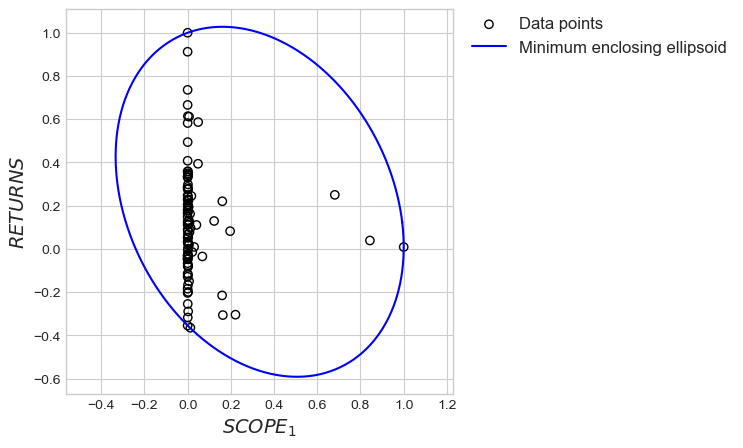

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from rsome import ro
from rsome import msk_solver as msk
import rsome as rso
#prices = yf.Tickers(' '.join(list(df.Ticker.unique()))).history(start='2020-01-01', end='2020-12-31')
returns = (prices.Close.iloc[-1] / prices.Close.iloc[0])
returns = returns.reset_index().rename(columns={0:'RETURNS'})
test = df.copy()[['INTENSITY', 'Ticker']].merge(returns, on ='Ticker')
test['ESG_PERF'] = test['Scope 1'] / copy.RETURNS
data = test[['INTENSITY_1', 'RETURNS']].apply(lambda x: x / x.max()).values

m = data.shape[0]
model = ro.Model()
P = model.dvar((2, 2))
c = model.dvar(2)
Z = rso.tril(model.dvar((2, 2)))
v = model.dvar(2)
model.max(v.sum())
model.st(v <= rso.log(rso.diag(Z)))
model.st(rso.rstack([P, Z],  [Z.T, rso.diag(Z, fill=True)]) >> 0)
for i in range(m):
    model.st(rso.norm(P@xs[i] - c) <= 1)
model.st(P >> 0)
model.solve(msk)

Ps = P.get()
cs = c.get()
step = 0.01
t = np.arange(0, 2*np.pi+step, step)
y = np.vstack((np.cos(t), np.sin(t))).T
ellip = np.linalg.inv(Ps) @ (y + cs).T

plt.figure(figsize=(5, 5))
plt.scatter(xs[:, 0], xs[:, 1], 
            marker='o', facecolor='none', color='k', label='Data points')
plt.plot(ellip[0], ellip[1], color='b', 
         label='Minimum enclosing ellipsoid')
plt.legend(fontsize=12, bbox_to_anchor=(1.01, 1.02))
plt.axis('equal')
plt.xlabel(r'$SCOPE_1$', fontsize=14)
plt.ylabel(r'$RETURNS$', fontsize=14)
plt.show()

### Lets define a metric for ESG-Weighted Returns over which the uncertainty set will occur. For stock $j$,

$$\gamma = \left[\frac{\max_j{\lambda_j} -  \lambda_j}{\max_j{\lambda_j}}\right]^n r_j $$

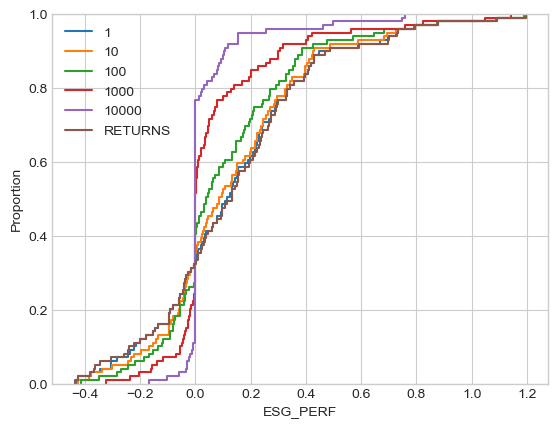

In [219]:
%matplotlib inline
for n in [1, 10, 100, 1000, 10000]:
    test['ESG_NORM'] = ((test['INTENSITY_1'].max() - test['INTENSITY_1']) / test['INTENSITY_1'].max()) ** n
    test['ESG_PERF'] = test.ESG_NORM * test.RETURNS
    sns.ecdfplot(test.ESG_PERF, label=n)
sns.ecdfplot(test.RETURNS, label='RETURNS')    
plt.legend()    

#### These are companies with the strongest ESG-weighted Returns

In [223]:
n = 1000
test['ESG_NORM'] = ((test['INTENSITY_1'].max() - test['INTENSITY_1']) / test['INTENSITY_1'].max()) ** n
test[test['ESG_PERF'] > 0].sort_values('ESG_PERF', ascending=False).head(10)

,Corporates,Sectors,Revenue,Scope 1,Scope 2 (Loc),Scope 2,Scope 3,Ticker,INTENSITY_1,INTENSITY_1_RANK,INTENSITY_2,INTENSITY_2_RANK,INTENSITY_3,INTENSITY_3_RANK,RETURNS,ESG_PERF,ESG_NORM
95,Nvidia,Information Technology,16.7,2817.0,74692.0,65936.0,1296150.0,NVDA,168.682635,96.0,3948.263473,58.0,77613.772455,51.0,1.195397,0.759440,0.955648
97,PayPal,Financials,21.4,3000.0,NaN,22100.0,2500.0,PYPL,140.186916,98.0,1032.710280,72.0,116.822430,85.0,1.090384,0.747901,0.963000
94,Apple Inc.,Information Technology,274.1,47430.0,890200.0,0.0,22547000.0,AAPL,173.039037,95.0,0.000000,88.0,82258.299891,49.0,0.796235,0.499959,0.954529
85,Advanced Micro Devices,Information Technology,9.8,2335.0,47797.0,30552.0,5690889.0,AMD,238.265306,86.0,3117.551020,64.0,580702.959184,23.0,0.879633,0.463457,0.937931
92,BlackRock Inc.,Financials,16.9,3278.0,19363.0,1011.0,226206.0,BLK,193.964497,93.0,59.822485,82.0,13384.970414,75.0,0.428500,0.254333,0.949173
82,Salesforce,Information Technology,21.3,6000.0,291000.0,135000.0,876000.0,CRM,281.690141,83.0,6338.028169,52.0,41126.760563,57.0,0.331816,0.155555,0.927040
98,United Health Group,Health Care,257.1,24487.0,156751.0,148741.0,213495.0,UNH,95.243096,99.0,578.533644,75.0,830.396733,79.0,0.198864,0.153927,0.974711
90,Alphabet Inc. Google,Communication Services,182.4,38694.0,5865095.0,911415.0,9376000.0,GOOG,212.138158,91.0,4996.792763,56.0,51403.508772,56.0,0.272165,0.153836,0.944545
79,"Meta Platforms, Inc",Communication Services,86.0,29000.0,2718000.0,9000.0,5091521.0,META,337.209302,80.0,104.651163,78.0,59203.732558,54.0,0.295977,0.119507,0.913300
84,Oracle,Information Technology,40.5,10300.0,580770.0,369300.0,1552018.0,ORCL,254.320988,85.0,9118.518519,43.0,38321.432099,61.0,0.214699,0.108339,0.933889


### These are companies that performed poorly and had a large GHG footprint.

In [224]:
test[test['RETURNS'] < 0].sort_values('ESG_NORM', ascending=True).head(10)

,Corporates,Sectors,Revenue,Scope 1,Scope 2 (Loc),Scope 2,Scope 3,Ticker,INTENSITY_1,INTENSITY_1_RANK,INTENSITY_2,INTENSITY_2_RANK,INTENSITY_3,INTENSITY_3_RANK,RETURNS,ESG_PERF,ESG_NORM
3,ConocoPhillips,Energy,18.8,15482352.0,667660.0,NaN,162700000.0,COP,823529.361702,4.0,NaN,NaN,8.654255e+06,1.0,-0.364241,-0.000000e+00,1.877378e-109
5,Exxon Mobil,Energy,178.2,108000000.0,0.0,7000000.0,540000000.0,XOM,606060.606061,6.0,39281.705948,6.0,3.030303e+06,5.0,-0.366399,-0.000000e+00,5.384972e-78
7,Chevron,Energy,94.4,56000000.0,NaN,1000000.0,588000000.0,CVX,593220.338983,8.0,10593.220339,39.0,6.228814e+06,2.0,-0.257473,-0.000000e+00,3.305326e-76
9,Exelon,Utilities,33.5,8492517.0,5227670.0,4477629.0,88521404.0,EXC,253507.970149,10.0,133660.567164,3.0,2.642430e+06,7.0,-0.041891,-9.107495e-309,2.156390e-31
14,American Tower,Real Estate,8.0,635108.0,517211.0,507304.0,3857549.0,AMT,79388.500000,15.0,63413.000000,5.0,4.821936e+05,28.0,-0.017446,-3.275614e-96,4.239941e-10
17,Schlumberger Ltd.,Energy,23.6,1125000.0,NaN,511000.0,38127000.0,SLB,47669.491525,18.0,21652.542373,18.0,1.615551e+06,11.0,-0.436423,-4.018689e-57,2.491252e-06
21,Intel Corp.,Information Technology,77.9,1973000.0,3700000.0,909000.0,10960000.0,INTC,25327.342747,22.0,11668.806162,35.0,1.406932e+05,41.0,-0.178794,-3.714745e-31,1.075865e-03
34,General Electric,Industrials,75.8,730000.0,NaN,1160000.0,NaN,GE,9630.606860,35.0,15303.430079,28.0,NaN,NaN,-0.096550,-5.272768e-13,7.477018e-02
35,Boeing,Industrials,58.2,554000.0,761000.0,526000.0,243092000.0,BA,9518.900344,36.0,9037.800687,44.0,4.176838e+06,3.0,-0.346096,-2.554385e-12,7.705644e-02
36,Raytheon Technologies,Industrials,56.7,536565.0,1002041.0,1020914.0,10939902.0,RTX,9463.227513,37.0,18005.537919,22.0,1.929436e+05,38.0,-0.238365,-2.044194e-12,7.822182e-02


### A ESG-Robust Portfolio

- $\gamma_i$: ESG-Weighted Return

- $z: = \{z: ||z||_{\infty} \leq 1 ||z||_1 \leq \Delta \}$: Uncertainty Set

- $[p_i - \delta_i, p_i + \delta_i]$: Box uncertainty

- $x_i$: Weight for stock $i$ (decision variable)

$$\begin{align}
\max~&\min\limits_{\pmb{z}\in\mathcal{Z}} \sum\limits_{i=1}^n\left(\gamma_i + \delta_iz_i \right)x_i \\
\text{s.t.}~&\sum\limits_{i=1}^nx_i = 1 \\
&x_i \geq 0, ~\forall i = 1, 2, ..., n,
\end{align}$$

In [332]:
test = test.drop(test.columns[-6:], axis=1)

In [333]:
n = 1
test['ESG_NORM'] = ((test['INTENSITY_1'].max() - test['INTENSITY_1']) / test['INTENSITY_1'].max()) ** n

In [334]:
average_prices = (prices.Close.pct_change().mean()).reset_index().rename(columns={0:'AVERAGE'})
deviation = (prices.Close.pct_change().std()).reset_index().rename(columns={0:'DEVIATION'})
uncertainty = 5
test  = test.merge(average_prices, on = 'Ticker')
test = test.merge(deviation, on = 'Ticker')
test['ADJ_RETURNS'] = test.ESG_NORM * test.AVERAGE
test['ADJ_DEVIATION'] = (test.ESG_NORM ** 2) * test.DEVIATION

In [383]:
test.set_index('Ticker')['ADJ_DEVIATION'].mul(minvol).sum() / test.set_index('Ticker')['ADJ_DEVIATION'].mul(weights).sum()

1.3448925106704968

In [381]:
test.set_index('Ticker')['ADJ_DEVIATION'].mul(minvol).sum()

0.032797824395621414

In [335]:
test = test[test.ADJ_DEVIATION > 0]


Being solved by Gurobi...
Solution status: 2
Running time: 0.0013s


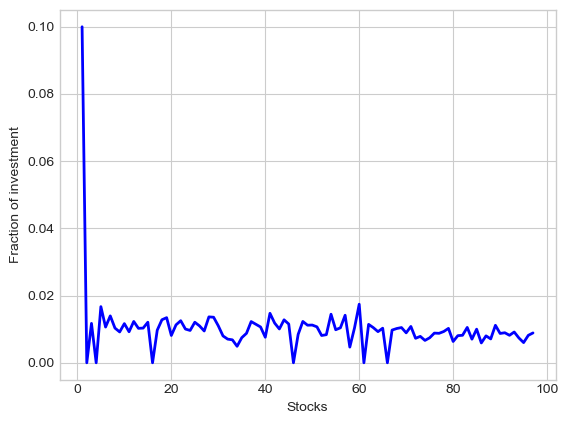

Objective value: -0.0004
Being solved by Gurobi...
Solution status: 2
Running time: 0.0013s


In [336]:
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
import numpy as np

n = len(test)
i = np.arange(1, len(test))                   # indices of stocks
p = np.array(test.ADJ_RETURNS)                   # mean returns
delta = np.array(test.ADJ_DEVIATION)   # deviations of returns
Gamma = 5                               # budget of uncertainty

model = ro.Model()              
x = model.dvar(n)                       # fractions of investment
z = model.rvar(n)                       # random variables

model.maxmin((p + delta*z) @ x,         # the max-min objective
             rso.norm(z, np.infty) <=1, # uncertainty set constraints
             rso.norm(z, 1) <= Gamma)   # uncertainty set constraints
model.st(sum(x) == 1)                   #import matplotlib.pyplot as plt
model.st(x >= 0)
model.st(x <= 0.1)
model.solve(grb) 
obj_val = model.get()                   # the optimal objective value
x_sol = x.get()                         # the optimal investment decision

plt.plot(range(1, n+1), x_sol, linewidth=2, color='b')
plt.xlabel('Stocks')
plt.ylabel('Fraction of investment')
plt.show()
print('Objective value: {0:0.4f}'.format(obj_val))
model.st(x >= 0)                        # x is non-negative

model.solve(grb)                        # solve the model by Gurobi
weights = pd.Series(x_sol, index=test.Ticker)

In [337]:
weights = pd.Series(x_sol, index=test.Ticker)

In [326]:
returns = prices.Close.pct_change()

In [347]:
import cvxpy as cp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import yfinance as yf
plt.style.use('seaborn-whitegrid')
HOME = os.environ['HOME']  + '/Documents/ESG/'

from itertools import combinations
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union



def process_data(year: int = 2020) -> pd.DataFrame:
    df = pd.read_csv(HOME + '/{year}_data.csv'.format(year=year)).drop('Unnamed: 0', axis=1).rename(columns={'Scope 2 (Mkt)': 'Scope 2'}) ##### GHG in mtCO2e
    df.loc[df.Ticker == 'ATT', 'Ticker'] = 'T'
    for col in list(df.columns[2:-1]):
        df[col] = df[col].str.replace(',', '').str.replace(' billion', '000000000').astype(float)
    for k in range(1,4):
        df['INTENSITY_{}'.format(k)] = df['Scope {}'.format(k)] / df.Revenue
        df['INTENSITY_{}_RANK'.format(k)] = df['INTENSITY_{}'.format(k)].rank(ascending=False)
    return df.sort_values('INTENSITY_1', ascending=False).reset_index(drop=True)


def fetch_weights(returns: pd.DataFrame,
                  min_weight: float = 0,
                  max_weight: float = 0.1,
                  max_intensity: float = 1e6,
                  intensity: pd.DataFrame = None,
                  aversion: int = 1) -> pd.Series:
    universe = list(set(returns.columns) & set(df[df.INTENSITY_1.notnull()].Ticker))
    returns = returns[universe].tail(10)
    Sigma = np.array(returns.cov())
    Sigma = Sigma.T.dot(Sigma)
    m,n = returns.shape
    mu = np.array(returns.mean(axis=0))
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T @ w
    risk = cp.quad_form(w, Sigma)
    gamma.value = aversion    
    constraints = [cp.sum(w) == 1, w >= min_weight, w <= max_weight]
    if isinstance(intensity, pd.DataFrame): 
        intensity = np.array(df[df.Ticker.isin(universe)].sort_values('Ticker')['INTENSITY_1'])
        constraints.append(intensity @ w <= max_intensity)        
    prob = cp.Problem(cp.Maximize(ret -  gamma * risk), constraints)
    prob.solve()
    return pd.Series(w.value, index=returns.columns).sort_values()

def fetch_performance(returns: pd.DataFrame, weights: pd.Series) -> None:
    return (1 + weights.mul(returns).sum(axis=1)).cumprod() - 1

def pdmdd(prices:pd.Series):
    return (prices - prices.rolling(len(prices), min_periods=1).max()).min()

def fetch_stats(returns: pd.DataFrame, weights: pd.Series) -> None:
    perf = weights.mul(returns).sum(axis=1)
    sharpe = np.sqrt(252) * perf.mean() / perf.std()
    sortino = np.sqrt(252) * perf.mean() / perf[perf < 0].std()
    drawdown = pdmdd(perf)
    perf.index = pd.DatetimeIndex(perf.index)
    cumulative = perf.groupby(perf.index.year).apply(lambda x: ((1+x).cumprod() - 1).iloc[-1]).mean()
    return pd.Series([sharpe, sortino, drawdown, cumulative], index=['Sharpe', 'Sortino', 'MDD', 'ANNUAL'])

### Performance Comparison

In this section we compare the ESG robust portfolio to minimum volatility and equal weighted. Whi

### Top Weights for MinVol

<AxesSubplot:>

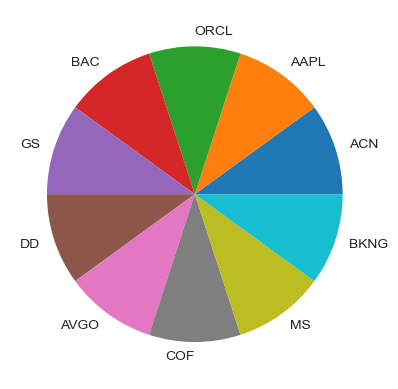

In [355]:
%matplotlib inline
minvol.tail(10).plot(kind='pie')

### Top Weights for ESG-Robust

<AxesSubplot:>

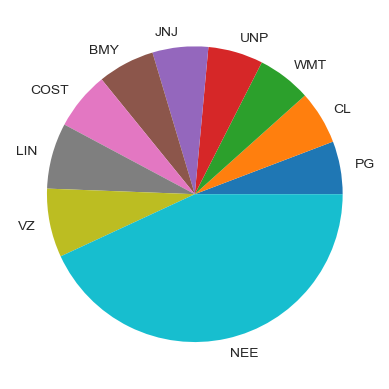

In [356]:
%matplotlib inline
weights.sort_values().tail(10).plot(kind='pie')

### Why NEE

In [358]:
test[test.Ticker == 'NEE'].T

,1
Corporates,Nextera Energy Inc.
Sectors,Utilities
Revenue,17.1
Scope 1,43311568.0
Scope 2 (Loc),14539.0
Scope 2,15114.0
Scope 3,6017.0
Ticker,NEE
INTENSITY_1,2532840.233918
INTENSITY_1_RANK,3.0


,MINVOL,ESG,EW
Sharpe,0.706566,0.767326,0.608182
Sortino,0.902387,0.883183,0.697354
MDD,-0.277296,-0.206544,-0.086673
ANNUAL,0.241649,0.223397,0.079216


Text(0.5, 1.0, 'Performance Comparison')

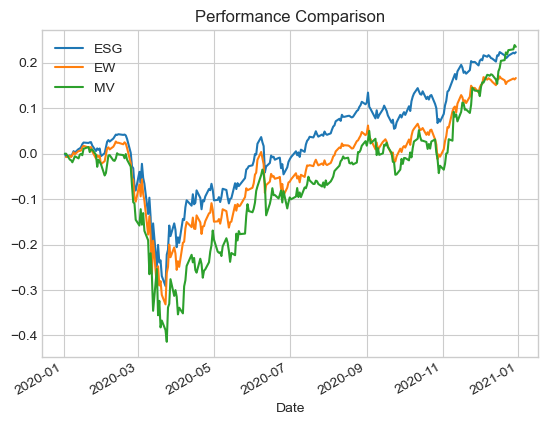

In [349]:
%matplotlib inline


minvol = fetch_weights(returns=returns.shift(), aversion=1000, max_intensity=1e12)
minvol_perf = fetch_performance(returns=returns.shift(), weights=minvol)

display(pd.concat([fetch_stats(returns=returns, weights=minvol),
           fetch_stats(returns=returns, weights=weights),
                   fetch_stats(returns=returns, weights=returns.iloc[0].fillna(1/len(returns)))], axis=1, keys=['MINVOL', 'ESG', 'EW']))
                                
                                
cumret = (1 + prices.Close.pct_change().mul(weights).sum(axis=1)).cumprod() - 1
cumret.plot(label='ESG')
((1 + prices.Close.pct_change().mean(axis=1)).cumprod() - 1).plot(label='EW')
minvol_perf.plot(label='MV')
plt.legend()
plt.title('Performance Comparison')